<a id='top'></a>
# How to slice and dice the data
Below are a series of examples on how to slice and dice the data that is stored in the *.sqlite* file generated by the [MorningStar.com](https://www.morningstar.com) web scraper. 

##### NOTE: 
- The data used in the code below come from the *.sqlite* file that is automatically generated by the web scraper once it has been installed and ran locally on your machine. See [README]() for instructions on how to run install and run the scraper.
- Navigation links only when using [Jupyter notebook](https://jupyter.org/).


**Content** 

1. [Required modules and matplotlib backend](#modules)
1. [Creating a master (bridge table) DataFrame instance using the DataFrames class](#master)
1. [Methods for creating DataFrame instances](#methods)
    1. `quoteheader` - [MorningStar (MS) Quote Header](#quote)
    1. `valuation` - [MS Valuation table with Price Ratios (P/E, P/S, P/B, P/C) for the past 10 yrs](#val)
    1. `keyratios` - [MS Ratio - Key Financial Ratios & Values](#keyratios)
    1. `finhealth` - [MS Ratio - Financial Health](#finhealth)
    1. `profitability` - [MS Ratio - Profitability](#prof)
    1. `growth` - [MS Ratio - Growth](#growth)
    1. `cfhealth` - [MS Ratio - Cash Flow Health](#cfh)
    1. `efficiency` - [MS Ratio - Efficiency](#eff)
    1. `annualIS` - [MS Annual Income Statements](#isa)
    1. `quarterlyIS` - [MS Quarterly Income Statements](#isq)
    1. `annualBS` - [MS Annual Balance Sheets](#bsa)
    1. `quarterlyBS` - [MS Quarterly Balance Sheets](#bsq)
    1. `annualCF` - [MS Annual Cash Flow Statements](#cfa)
    1. `quarterlyCF` - [MS Quarterly Cash Flow Statements](#cfq)
    1. `insider_trades` - [Insider Transactions](#it)
1. [Performing statistical analysis](#stats)
    1. [Count of database records](#stats)
    1. [Last updated dates](#lastupdate)
    1. [Number of records by security type](#type)
    1. [Number of records by country, based on the location of exchanges](#country)
    1. [Number of records per exchange](#exchange)
    1. [Number of stocks by sector](#sector)
    1. [Number of stocks by industry](#industry)
    1. [Mean price ratios (P/E, P/S, P/B, P/CF) of stocks by sectors](#meanpr)
1. [Applying various criteria to filter common stocks](#value) *(in progress)*
1. [Additional sample / test code](#additional) *(in progress)*

<a id="modules"></a>
# Required modules and matplotlib backend

In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import dataframes #module containing class used to create DataFrame objects from SQLite database file
import datetime as DT
import re

# Reload in case changes have been made to module file
from importlib import reload
reload(dataframes);

[return to the top](#top)
<a id="master"></a>
# Creating the master DataFrame instance
The DataFrames class is part of the [dataframes module](dataframes.py)

In [2]:
db_file_name = 'mstables' # SQLite database file that contains the data to be analyzed
df = dataframes.DataFrames('db/{}.sqlite'.format(db_file_name))

Creating initial DataFrames objects from file db/mstables.sqlite...

	- DataFrame 'df.colheaders' ...
	- DataFrame 'df.timerefs' ...
	- DataFrame 'df.urls' ...
	- DataFrame 'df.securitytypes' ...
	- DataFrame 'df.tickers' ...
	- DataFrame 'df.sectors' ...
	- DataFrame 'df.industries' ...
	- DataFrame 'df.stockstyles' ...
	- DataFrame 'df.exchanges' ...
	- DataFrame 'df.countries' ...
	- DataFrame 'df.companies' ...
	- DataFrame 'df.currencies' ...
	- DataFrame 'df.stocktypes' ...
	- DataFrame 'df.master' ...

Initial DataFrames created successfully.


## Creating Master DataFrame instance from reference tables
Merge `df.master` (*Master* bridge table) with other reference tables (e.g. `df.tickers`, `df.exchanges`, etc.) and filter out inactive / invalid records.
### DataFrame Instance
Create `df_master`

In [3]:
df_master = df.master.copy()

Apply the following filter:
<br>
- $lastdate < cutoff\_date$
<br>
- $cutoff\_date = date one\ week\ prior\ to\ last\ date\ the\ database\ was\ updated$
<br>
<br>
This filter ensure that only active records are included in the master dataframe, excluding inactive MorningStar records which are no longer being updated on a regular basis. These inactive records are typically symbols that are no longer active in their exchange.

In [135]:
cutoff_days = 10
df_updated_ct = df_master[['update_date', 'ticker']].groupby('update_date').count().sort_index()
cutoff_date = df_updated_ct[df_updated_ct['ticker'] > 100].index[0] - DT.timedelta(days=cutoff_days)

df_master = df_master.where(df_master['lastdate'] >= cutoff_date).dropna(axis=0, how='all')

#### DataFrame Size

In [5]:
msg = 'DataFrame df_master contains {:,.0f} records and {:,.0f} columns.'
print(msg.format(df_master.shape[0], df_master.shape[1]))

DataFrame df_master contains 100,186 records and 33 columns.


#### DataFrame Columns

In [6]:
df_master.columns.values

array(['ticker_id', 'exchange_id', 'update_date', 'ticker', 'company',
       'exchange', 'exchange_sym', 'industry', 'sector', 'country',
       'country_c2', 'country_c3', 'security_type_code', 'security_type',
       'stock_type', 'style', 'openprice', 'lastprice', 'day_hi',
       'day_lo', '_52wk_hi', '_52wk_lo', 'yield', 'lastvol', 'avevol',
       'PE_Forward', 'pb', 'ps', 'pc', 'lastdate', 'currency',
       'currency_code', 'fy_end'], dtype=object)

<br></br>
[return to the top](#top)
<a id='methods'></a>
# Creating DataFrame instances with dataframes methods
Class DataFrames from [dataframe.py](dataframe.py) contains the following methods that return a pd.DataFrame object for the specified database table:

- `quoteheader` - [MorningStar (MS) Quote Header](#quote)
- `valuation` - [MS Valuation table with Price Ratios (P/E, P/S, P/B, P/C) for the past 10 yrs](#val)
- `keyratios` - [MS Ratio - Key Financial Ratios & Values](#keyratios)
- `finhealth` - [MS Ratio - Financial Health](#finhealth)
- `profitability` - [MS Ratio - Profitability](#prof)
- `growth` - [MS Ratio - Growth](#growth)
- `cfhealth` - [MS Ratio - Cash Flow Health](#cfh)
- `efficiency` - [MS Ratio - Efficiency](#eff)
- `annualIS` - [MS Annual Income Statements](#isa)
- `quarterlyIS` - [MS Quarterly Income Statements](#isq)
- `annualBS` - [MS Annual Balance Sheets](#bsa)
- `quarterlyBS` - [MS Quarterly Balance Sheets](#bsq)
- `annualCF` - [MS Annual Cash Flow Statements](#cfa)
- `quarterlyCF` - [MS Quarterly Cash Flow Statements](#cfq)
- `insider_trades` - [Insider Transactions](#it)

<a id='quote'></a>
### Quote Header 
##### DataFrame Instance

In [8]:
df_quote = df.quoteheader()

In [9]:
df_quote.head()

,ticker_id,exchange_id,openprice,lastprice,day_hi,day_lo,_52wk_hi,_52wk_lo,yield,lastvol,avevol,fpe,pb,ps,pc,currency_id,lastdate
0,1,374,15.49,15.51,15.55,15.49,17.72,12.16,2.05,12002.0,2830.0,NaN,2.3,6.3,16.4,104.0,2019-05-01
1,2,374,15.29,15.28,15.29,15.28,17.68,13.68,2.06,340.0,1991.0,NaN,2.3,6.2,16.3,104.0,2019-04-30
2,3,374,15.50,15.56,15.6,15.47,17.79,11.99,2.04,15508.0,11119.0,NaN,2.4,6.3,16.5,104.0,2019-05-01
3,4,482,101.23,101.06,102,100.76,115.11,87.87,1.18,137300.0,753897.0,22.6,3.5,4.1,21.3,104.0,2019-05-01
4,5,1,0.00,0,0,0,0,0,NaN,500.0,342.0,NaN,NaN,NaN,NaN,104.0,2019-04-25


##### DataFrame Length

In [10]:
print('DataFrame contains {:,.0f} records.'.format(len(df_quote)))

DataFrame contains 119,481 records.


<a id='val'></a>
[return to the top](#top)
### Price Ratios (P/E, P/S, P/B, P/C)
##### DataFrame Instance

In [7]:
df_vals = df.valuation().reset_index()

##### DataFrame Length

In [8]:
print('DataFrame contains {:,.0f} records.'.format(len(df_vals)))

DataFrame contains 81,620 records.


##### DataFrame Columns

In [9]:
df_vals.columns

Index(['exchange_id', 'ticker_id', 'PE_2009', 'PE_2010', 'PE_2011', 'PE_2012',
       'PE_2013', 'PE_2014', 'PE_2015', 'PE_2016', 'PE_2017', 'PE_2018',
       'PE_TTM', 'PS_2009', 'PS_2010', 'PS_2011', 'PS_2012', 'PS_2013',
       'PS_2014', 'PS_2015', 'PS_2016', 'PS_2017', 'PS_2018', 'PS_TTM',
       'PB_2009', 'PB_2010', 'PB_2011', 'PB_2012', 'PB_2013', 'PB_2014',
       'PB_2015', 'PB_2016', 'PB_2017', 'PB_2018', 'PB_TTM', 'PC_2009',
       'PC_2010', 'PC_2011', 'PC_2012', 'PC_2013', 'PC_2014', 'PC_2015',
       'PC_2016', 'PC_2017', 'PC_2018', 'PC_TTM'],
      dtype='object')

<a id='keyratios'></a>
[return to the top](#top)
### Key Ratios
##### DataFrame Instance

In [10]:
df_keyratios = df.keyratios()

##### DataFrame Length

In [11]:
print('DataFrame contains {:,.0f} records.'.format(len(df_keyratios)))

DataFrame contains 78,939 records.


##### DataFrame Columns

In [12]:
df_labels_keyratios = (df_keyratios
                     .loc[0, [col for col in df_keyratios.columns if 'Y' not in col and col.startswith('i')]]
                     .replace(df.colheaders['header']))
df_labels_keyratios

i0                    Revenue USD Mil
i1                     Gross Margin %
i2           Operating Income USD Mil
i3                 Operating Margin %
i4                 Net Income USD Mil
i5             Earnings Per Share USD
i6                      Dividends USD
i91                  Payout Ratio % *
i7                         Shares Mil
i8         Book Value Per Share * USD
i9        Operating Cash Flow USD Mil
i10              Cap Spending USD Mil
i11            Free Cash Flow USD Mil
i90    Free Cash Flow Per Share * USD
i80           Working Capital USD Mil
Name: 0, dtype: object

<a id='finhealth'></a>
[return to the top](#top)
### Financial Health
##### DataFrame Instance

In [13]:
df_finhealth = df.finhealth()

##### DataFrame Length

In [14]:
print('DataFrame contains {:,.0f} records.'.format(len(df_finhealth)))

DataFrame contains 78,934 records.


##### DataFrame Columns

In [15]:
df_labels_finhealth = (df_finhealth.loc[0, [col for col in df_finhealth.columns 
                                          if 'Y' not in col and '_id' not in col]]
                     .replace(df.colheaders['header']))
df_labels_finhealth

fh_balsheet         Balance Sheet Items (in %)
i45              Cash & Short-Term Investments
i46                        Accounts Receivable
i47                                  Inventory
i48                       Other Current Assets
i49                       Total Current Assets
i50                                   Net PP&E
i51                                Intangibles
i52                     Other Long-Term Assets
i53                               Total Assets
i54                           Accounts Payable
i55                            Short-Term Debt
i56                              Taxes Payable
i57                        Accrued Liabilities
i58               Other Short-Term Liabilities
i59                  Total Current Liabilities
i60                             Long-Term Debt
i61                Other Long-Term Liabilities
i62                          Total Liabilities
i63                  Total Stockholders Equity
i64                 Total Liabilities & Equity
lfh_liquidity

<a id='prof'></a>
[return to the top](#top)
### Profitability
##### DataFrame Instance

In [197]:
df_profitab = df.profitability()

In [198]:
df_profitab.head()

,ticker_id,exchange_id,pr_margins,i12,i12_pr_Y0,i12_pr_Y1,i12_pr_Y2,i12_pr_Y3,i12_pr_Y4,i12_pr_Y5,...,pr_Y1,pr_Y2,pr_Y3,pr_Y4,pr_Y5,pr_Y6,pr_Y7,pr_Y8,pr_Y9,pr_Y10
0,1,374,279,202,NaN,NaN,100.0,100.0,100.0,100.0,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM
1,2,374,279,202,NaN,NaN,100.0,100.0,100.0,100.0,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM
2,3,374,279,202,NaN,NaN,100.0,100.0,100.0,100.0,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM
3,4,482,279,202,100.0,100.0,100.0,100.0,100.0,100.0,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM
4,23,1,279,202,100.0,100.0,100.0,100.0,100.0,100.0,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM


##### DataFrame Length

In [199]:
print('DataFrame contains {:,.0f} records.'.format(len(df_profitab)))

DataFrame contains 78,934 records.


##### DataFrame Columns

In [201]:
df_labels_profitab = (df_profitab.loc[0, [col for col in df_profitab.columns if 'Y' not in col and '_id' not in col]]
                    .replace(df.colheaders['header']))
df_labels_profitab

pr_margins              Margins % of Sales
i12                                Revenue
i13                                   COGS
i14                           Gross Margin
i15                                   SG&A
i16                                    R&D
i17                                  Other
i18                       Operating Margin
i19                    Net Int Inc & Other
i20                             EBT Margin
pr_profit                    Profitability
i21                             Tax Rate %
i22                           Net Margin %
i23               Asset Turnover (Average)
i24                     Return on Assets %
i25           Financial Leverage (Average)
i26                     Return on Equity %
i27           Return on Invested Capital %
i95                      Interest Coverage
Name: 0, dtype: object

<a id='growth'></a>
[return to the top](#top)
### Growth
##### DataFrame Instance

In [20]:
df_growth = df.growth()

In [21]:
df_growth.head()

,ticker_id,exchange_id,gr_revenue,i28,i28_gr_Y0,i28_gr_Y1,i28_gr_Y2,i28_gr_Y3,i28_gr_Y4,i28_gr_Y5,...,gr_Y1,gr_Y2,gr_Y3,gr_Y4,gr_Y5,gr_Y6,gr_Y7,gr_Y8,gr_Y9,gr_Y10
0,1,374,298,299,NaN,NaN,NaN,-11.70,19.81,103.73,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,Latest Qtr
1,2,374,298,299,NaN,NaN,NaN,-11.70,19.81,103.73,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,Latest Qtr
2,3,374,298,299,NaN,NaN,NaN,-11.70,19.81,103.73,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,Latest Qtr
3,4,482,298,299,2.23,2.59,16.25,0.83,11.65,7.90,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,Latest Qtr
4,23,1,298,299,238.49,16.43,16.43,NaN,NaN,NaN,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,Latest Qtr


##### DataFrame Length

In [22]:
print('DataFrame contains {:,.0f} records.'.format(len(df_growth)))

DataFrame contains 78,934 records.


##### DataFrame Columns

In [23]:
df_labels_growth = (df_growth.loc[0, [col for col in df_growth.columns 
                                      if 'Y' not in col and '_id' not in col]].replace(df.colheaders['header']))
df_labels_growth

gr_revenue               Revenue %
i28                 Year over Year
i29                 3-Year Average
i30                 5-Year Average
i31                10-Year Average
gr_operating    Operating Income %
i32                 Year over Year
i33                 3-Year Average
i34                 5-Year Average
i35                10-Year Average
gr_ni                 Net Income %
i81                 Year over Year
i82                 3-Year Average
i83                 5-Year Average
i84                10-Year Average
gr_eps                       EPS %
i36                 Year over Year
i37                 3-Year Average
i38                 5-Year Average
i39                10-Year Average
Name: 0, dtype: object

<a id='cfh'></a>
[return to the top](#top)
### Cash Flow Health
##### DataFrame Instance

In [24]:
df_cfhealth = df.cfhealth()

In [25]:
df_cfhealth.head()

,ticker_id,exchange_id,cf_cashflow,i40,i40_cf_Y0,i40_cf_Y1,i40_cf_Y2,i40_cf_Y3,i40_cf_Y4,i40_cf_Y5,...,cf_Y1,cf_Y2,cf_Y3,cf_Y4,cf_Y5,cf_Y6,cf_Y7,cf_Y8,cf_Y9,cf_Y10
0,1,374,318,319,NaN,NaN,NaN,97.88,NaN,NaN,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM
1,2,374,318,319,NaN,NaN,NaN,97.88,NaN,NaN,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM
2,3,374,318,319,NaN,NaN,NaN,97.88,NaN,NaN,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM
3,4,482,318,319,-31.63,19.64,50.56,-1.28,11.89,17.06,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM
4,23,1,318,319,NaN,51.78,51.78,NaN,NaN,NaN,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM


##### DataFrame Length

In [26]:
print('DataFrame contains {:,.0f} records.'.format(len(df_cfhealth)))

DataFrame contains 78,934 records.


##### DataFrame Columns

In [27]:
df_labels_cfhealth = df_cfhealth.loc[0, [col for col in df_cfhealth.columns if 'Y' not in col 
                                         and '_id' not in col]].replace(df.colheaders['header'])
df_labels_cfhealth

cf_cashflow                    Cash Flow Ratios
i40            Operating Cash Flow Growth % YOY
i41                 Free Cash Flow Growth % YOY
i42                      Cap Ex as a % of Sales
i43                      Free Cash Flow/Sales %
i44                   Free Cash Flow/Net Income
Name: 0, dtype: object

<a id='eff'></a>
[return to the top](#top)
### Efficiency
##### DataFrame Instance

In [28]:
df_efficiency = df.efficiency()

In [29]:
df_efficiency.head()

,ticker_id,exchange_id,ef_efficiency,i69,i69_ef_Y0,i69_ef_Y1,i69_ef_Y2,i69_ef_Y3,i69_ef_Y4,i69_ef_Y5,...,ef_Y1,ef_Y2,ef_Y3,ef_Y4,ef_Y5,ef_Y6,ef_Y7,ef_Y8,ef_Y9,ef_Y10
0,1,374,350,351,NaN,NaN,NaN,82.34,85.86,61.96,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM
1,2,374,350,351,NaN,NaN,NaN,82.34,85.86,61.96,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM
2,3,374,350,351,NaN,NaN,NaN,82.34,85.86,61.96,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM
3,4,482,350,351,25.66,28.47,27.05,29.65,30.48,32.01,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM
4,23,1,350,351,93.87,58.87,58.87,11.21,11.21,84.13,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM


##### DataFrame Length

In [30]:
print('DataFrame contains {:,.0f} records.'.format(len(df_efficiency)))

DataFrame contains 78,934 records.


##### DataFrame Columns

In [31]:
# Financial Health DataFrame Columns
(df_efficiency.loc[0, [col for col in df_efficiency.columns if 'Y' not in col and '_id' not in col]]
 .replace(df.colheaders['header']))

ef_efficiency                Efficiency
i69              Days Sales Outstanding
i70                      Days Inventory
i71                     Payables Period
i72               Cash Conversion Cycle
i73                Receivables Turnover
i74                  Inventory Turnover
i75               Fixed Assets Turnover
i76                      Asset Turnover
Name: 0, dtype: object

<a id='isa'></a>
[return to the top](#top)
### Annual Income Statement
##### DataFrame Instance

In [32]:
df_annualIS = df.annualIS()

##### DataFrame Length

In [33]:
print('DataFrame contains {:,.0f} records.'.format(len(df_annualIS)))

DataFrame contains 78,939 records.


##### DataFrame Columns

In [34]:
labels = [col for col in df_annualIS if 'label' in col]
labels = [[label, header] for label in labels 
          for header in df_annualIS[label].unique().tolist() if pd.notna(header)]

df_labels_aIS = (pd.DataFrame(labels, columns=['header', 'value']).set_index('header').astype('int'))
df_labels_aIS['value'] = df_labels_aIS['value'].replace(df.colheaders['header'])
df_labels_aIS[df_labels_aIS['value'].astype('str').str.contains('ncome')].sort_values(by='value')

sorted(list(zip(df_labels_aIS.values.tolist(), df_labels_aIS.index)))

[(['Advertising and market...'], 'label_i36'),
 (['Advertising and market...'], 'label_i46'),
 (['Advertising and promot...'], 'label_i15'),
 (['Amortization of intang...'], 'label_i47'),
 (['Asset impairment'], 'label_i24'),
 (['Asset mgmt and securit...'], 'label_i4'),
 (['Basic'], 'label_i83'),
 (['Basic'], 'label_i85'),
 (['Benefits, claims and e...'], 'label_s2'),
 (['Borrowed funds'], 'label_i14'),
 (['Commissions and fees'], 'label_i22'),
 (['Compensation and benef...'], 'label_i13'),
 (['Compensation and benef...'], 'label_i32'),
 (['Compensation and benef...'], 'label_i42'),
 (['Cost of revenue'], 'label_i6'),
 (['Costs and expenses'], 'label_g3'),
 (['Credit card income'], 'label_i27'),
 (['Cumulative effect of a...'], 'label_i43'),
 (['Cumulative effect of a...'], 'label_i66'),
 (['Cumulative effect of a...'], 'label_i73'),
 (['Deposits'], 'label_i12'),
 (['Deposits with banks'], 'label_i3'),
 (['Depreciation and amort...'], 'label_i12'),
 (['Depreciation and amort...'], 'la

<a id='isq'></a>
[return to the top](#top)
### Quarterly Income Statements
##### DataFrame Instance

In [35]:
df_quarterlyIS = df.quarterlyIS()

##### DataFrame Length

In [36]:
print('DataFrame contains {:,.0f} records.'.format(len(df_quarterlyIS)))

DataFrame contains 58,604 records.


##### DataFrame Columns

In [37]:
labels = [col for col in df_annualIS if 'label' in col]
labels = [[label, header] for label in labels 
          for header in df_annualIS[label].unique().tolist() if pd.notna(header)]

df_labels_aIS = (pd.DataFrame(labels, columns=['header', 'value']).set_index('header').astype('int'))
df_labels_aIS['value'] = df_labels_aIS['value'].replace(df.colheaders['header'])
df_labels_aIS[df_labels_aIS['value'].astype('str').str.contains('ncome')].sort_values(by='value')

sorted(list(zip(df_labels_aIS.values.tolist(), df_labels_aIS.index)))

[(['Advertising and market...'], 'label_i36'),
 (['Advertising and market...'], 'label_i46'),
 (['Advertising and promot...'], 'label_i15'),
 (['Amortization of intang...'], 'label_i47'),
 (['Asset impairment'], 'label_i24'),
 (['Asset mgmt and securit...'], 'label_i4'),
 (['Basic'], 'label_i83'),
 (['Basic'], 'label_i85'),
 (['Benefits, claims and e...'], 'label_s2'),
 (['Borrowed funds'], 'label_i14'),
 (['Commissions and fees'], 'label_i22'),
 (['Compensation and benef...'], 'label_i13'),
 (['Compensation and benef...'], 'label_i32'),
 (['Compensation and benef...'], 'label_i42'),
 (['Cost of revenue'], 'label_i6'),
 (['Costs and expenses'], 'label_g3'),
 (['Credit card income'], 'label_i27'),
 (['Cumulative effect of a...'], 'label_i43'),
 (['Cumulative effect of a...'], 'label_i66'),
 (['Cumulative effect of a...'], 'label_i73'),
 (['Deposits'], 'label_i12'),
 (['Deposits with banks'], 'label_i3'),
 (['Depreciation and amort...'], 'label_i12'),
 (['Depreciation and amort...'], 'la

<a id='bsa'></a>
[return to the top](#top)
### Annual Balance Sheet
##### DataFrame Instance

In [38]:
df_annualBS = df.annualBS()

##### DataFrame Length

In [39]:
print('DataFrame contains {:,.0f} records.'.format(len(df_annualBS)))

DataFrame contains 79,096 records.


##### DataFrame Columns

In [40]:
labels = [col for col in df_annualBS if 'label' in col]
labels = [[label, header] for label in labels 
          for header in df_annualBS[label].unique().tolist() if pd.notna(header)]

df_labels_aBS = (pd.DataFrame(labels, columns=['header', 'value']).set_index('header').astype('int'))
df_labels_aBS['value'] = df_labels_aBS['value'].replace(df.colheaders['header'])
df_labels_aBS[df_labels_aBS['value'].astype('str').str.contains('ncome')].sort_values(by='value')

sorted(list(zip(df_labels_aBS.values.tolist(), df_labels_aBS.index)))

[(['Accounts payable'], 'label_i41'),
 (['Accounts payable'], 'label_i42'),
 (['Accounts payable'], 'label_i43'),
 (['Accrued expenses and l...'], 'label_i46'),
 (['Accrued expenses and l...'], 'label_i47'),
 (['Accrued investment inc...'], 'label_i8'),
 (['Accrued liabilities'], 'label_i45'),
 (['Accrued liabilities'], 'label_i46'),
 (['Accrued liabilities'], 'label_i53'),
 (['Accumulated Depreciati...'], 'label_i10'),
 (['Accumulated Depreciati...'], 'label_i14'),
 (['Accumulated depreciati...'], 'label_i2'),
 (['Accumulated other comp...'], 'label_i89'),
 (['Additional paid-in cap...'], 'label_i84'),
 (['Allowance for loan los...'], 'label_i12'),
 (['Allowance for loan los...'], 'label_i9'),
 (['Assets'], 'label_g1'),
 (['Assets'], 'label_s1'),
 (['Buildings and improvem...'], 'label_i10'),
 (['Capital leases'], 'label_i42'),
 (['Capital leases'], 'label_i43'),
 (['Capital leases'], 'label_i51'),
 (['Cash'], 'label_gg1'),
 (['Cash and cash equivale...'], 'label_i1'),
 (['Cash and ca

<a id='bsq'></a>
[return to the top](#top)
### Quarterly Balance Sheet
##### DataFrame Instance

In [41]:
df_quarterlyBS = df.quarterlyBS()

##### DataFrame Length

In [42]:
print('DataFrame contains {:,.0f} records.'.format(len(df_quarterlyBS)))

DataFrame contains 78,725 records.


##### DataFrame Columns

In [43]:
labels = [col for col in df_quarterlyBS if 'label' in col]
labels = [[label, header] for label in labels 
          for header in df_quarterlyBS[label].unique().tolist() if pd.notna(header)]

df_labels_qBS = (pd.DataFrame(labels, columns=['header', 'value']).set_index('header').astype('int'))
df_labels_qBS['value'] = df_labels_qBS['value'].replace(df.colheaders['header'])
df_labels_qBS[df_labels_qBS['value'].astype('str').str.contains('ncome')].sort_values(by='value')

sorted(list(zip(df_labels_qBS.values.tolist(), df_labels_qBS.index)))

[(['Accounts payable'], 'label_i41'),
 (['Accounts payable'], 'label_i42'),
 (['Accounts payable'], 'label_i43'),
 (['Accrued expenses and l...'], 'label_i46'),
 (['Accrued expenses and l...'], 'label_i47'),
 (['Accrued investment inc...'], 'label_i8'),
 (['Accrued liabilities'], 'label_i45'),
 (['Accrued liabilities'], 'label_i46'),
 (['Accrued liabilities'], 'label_i53'),
 (['Accumulated Depreciati...'], 'label_i10'),
 (['Accumulated Depreciati...'], 'label_i14'),
 (['Accumulated depreciati...'], 'label_i2'),
 (['Accumulated other comp...'], 'label_i89'),
 (['Additional paid-in cap...'], 'label_i84'),
 (['Allowance for loan los...'], 'label_i12'),
 (['Allowance for loan los...'], 'label_i9'),
 (['Assets'], 'label_g1'),
 (['Assets'], 'label_s1'),
 (['Buildings and improvem...'], 'label_i10'),
 (['Capital leases'], 'label_i42'),
 (['Capital leases'], 'label_i43'),
 (['Capital leases'], 'label_i51'),
 (['Cash'], 'label_gg1'),
 (['Cash and cash equivale...'], 'label_i1'),
 (['Cash and ca

<a id='cfa'></a>
[return to the top](#top)
### Annual Cash Flow Statement
##### DataFrame Instance

In [44]:
df_annualCF = df.annualCF()

##### DataFrame Length

In [45]:
print('DataFrame contains {:,.0f} records.'.format(len(df_annualCF)))

DataFrame contains 78,532 records.


##### DataFrame Columns

In [46]:
labels = [col for col in df_annualCF if 'label' in col]
labels = [[label, header] for label in labels 
          for header in df_annualCF[label].unique().tolist() if pd.notna(header)]

df_labels_aCF = (pd.DataFrame(labels, columns=['header', 'value']).set_index('header').astype('int'))
df_labels_aCF['value'] = df_labels_aCF['value'].replace(df.colheaders['header'])
df_labels_aCF[df_labels_aCF['value'].astype('str').str.contains('ncome')].sort_values(by='value')

sorted(list(zip(df_labels_aCF.values.tolist(), df_labels_aCF.index)))

[(['(Gain) Loss from disco...'], 'label_i3'),
 (['(Gain) Loss from disco...'], 'label_i7'),
 (['(Gains) loss on dispos...'], 'label_i11'),
 (['(Gains) loss on dispos...'], 'label_i12'),
 (['Accounts payable'], 'label_i19'),
 (['Accounts payable'], 'label_i20'),
 (['Accounts receivable'], 'label_i16'),
 (['Accrued liabilities'], 'label_i20'),
 (['Accrued liabilities'], 'label_i21'),
 (['Accrued liabilities'], 'label_i30'),
 (['Acquisitions and dispo...'], 'label_i33'),
 (['Acquisitions and dispo...'], 'label_i36'),
 (['Acquisitions and dispo...'], 'label_i43'),
 (['Acquisitions, net'], 'label_i33'),
 (['Amortization of debt a...'], 'label_i7'),
 (['Amortization of debt d...'], 'label_i10'),
 (['Amortization of debt d...'], 'label_i3'),
 (['Amortization of debt d...'], 'label_i7'),
 (['Capital expenditure'], 'label_i96'),
 (['Capitalization of defe...'], 'label_i24'),
 (['Cash Flows From Financ...'], 'label_s3'),
 (['Cash Flows From Invest...'], 'label_s2'),
 (['Cash Flows From Operat...

<a id='cfq'></a>
[return to the top](#top)
### Quarterly Cash Flow Statement
##### DataFrame Instance

In [47]:
df_quarterlyCF = df.quarterlyCF()

##### DataFrame Length

In [48]:
print('DataFrame contains {:,.0f} records.'.format(len(df_quarterlyCF)))

DataFrame contains 78,980 records.


##### DataFrame Columns

In [49]:
labels = [col for col in df_quarterlyCF if 'label' in col]
labels = [[label, header] for label in labels 
          for header in df_quarterlyCF[label].unique().tolist() if pd.notna(header)]

df_labels_qCF = (pd.DataFrame(labels, columns=['header', 'value']).set_index('header').astype('int'))
df_labels_qCF['value'] = df_labels_qCF['value'].replace(df.colheaders['header'])
df_labels_qCF[df_labels_qCF['value'].astype('str').str.contains('ncome')].sort_values(by='value')

sorted(list(zip(df_labels_qCF.values.tolist(), df_labels_qCF.index)))

[(['(Gain) Loss from disco...'], 'label_i3'),
 (['(Gain) Loss from disco...'], 'label_i7'),
 (['(Gains) loss on dispos...'], 'label_i11'),
 (['(Gains) loss on dispos...'], 'label_i12'),
 (['Accounts payable'], 'label_i19'),
 (['Accounts payable'], 'label_i20'),
 (['Accounts receivable'], 'label_i16'),
 (['Accrued liabilities'], 'label_i20'),
 (['Accrued liabilities'], 'label_i21'),
 (['Accrued liabilities'], 'label_i30'),
 (['Acquisitions and dispo...'], 'label_i33'),
 (['Acquisitions and dispo...'], 'label_i36'),
 (['Acquisitions and dispo...'], 'label_i43'),
 (['Acquisitions, net'], 'label_i33'),
 (['Amortization of debt a...'], 'label_i7'),
 (['Amortization of debt d...'], 'label_i10'),
 (['Amortization of debt d...'], 'label_i3'),
 (['Amortization of debt d...'], 'label_i7'),
 (['Capital expenditure'], 'label_i96'),
 (['Capitalization of defe...'], 'label_i24'),
 (['Cash Flows From Financ...'], 'label_s3'),
 (['Cash Flows From Invest...'], 'label_s2'),
 (['Cash Flows From Operat...

<a id='it'></a>
[return to the top](#top)
### Insider Transactions
##### DataFrame Instance

In [50]:
df_insidertrades = df.insider_trades()

##### DataFrame Length

In [51]:
print('DataFrame contains {:,.0f} records.'.format(len(df_insidertrades)))

DataFrame contains 673,195 records.


<a id="stats"></a>
[return to the top](#top)
# Performing statistical analysis
### Count of database records
**1.** Total number of records **before** merging reference tables (length of `df.master0`)

In [52]:
print('DataFrame df.master contains {:,.0f} records.'.format(len(df.master0)))

DataFrame df.master contains 119,143 records.


**2.** Total number of records **after** merging reference tables (length of `df.master`)

In [55]:
print('DataFrame df_master0 contains {:,.0f} records.'.format(len(df.master)))

DataFrame df_master0 contains 111,831 records.


**3.** Total number of records **after** filtering out inactive records (length of `df_master`)

In [56]:
print('DataFrame df_master contains {:,.0f} records.'.format(len(df_master)))

DataFrame df_master contains 100,186 records.


<a id="lastupdate"></a>
[return to the top](#top)
### Last updated dates
List of dates (as a pd.Series object) of when the database records were last updated. 
The values indicate the number of records updated on each date.

In [57]:
(df_master[['update_date', 'ticker']].groupby(by='update_date').count().sort_index(ascending=False)
 .rename(columns={'ticker':'ticker_count'}))

,ticker_count
update_date,
2019-05-02,8
2019-05-01,53020
2019-04-30,47088
2019-04-27,35


<a id="type"></a>
[return to the top](#top)
### Number of records by Security Type

In [58]:
(df_master[['security_type', 'ticker']].groupby(by='security_type').count()
 .rename(columns={'ticker':'ticker_count'}))

,ticker_count
security_type,
Closed-End Fund,1182
Exchange-Traded Fund,6182
Index,499
Money Market Fund,197
Open-End Fund,25611
Stock,66515


<a id="country"></a>
[return to the top](#top)
### Number of records by Country, based on the location of exchanges

In [59]:
(df_master[['country', 'country_c3', 'ticker']]
 .groupby(by=['country', 'country_c3']).count().rename(columns={'ticker':'ticker_count'})
)

,,ticker_count
country,country_c3,
Australia,AUS,2028
Belgium,BEL,162
Canada,CAN,4135
China,CHN,3792
Finland,FIN,2
France,FRA,1193
Germany,DEU,35746
Hong Kong,HKG,2363
Ireland,IRL,1634


<a id="exchange"></a>
[return to the top](#top)
### Number of records per exchange
Where $ticker\_count > 100$

In [60]:
cols = ['country', 'country_c3', 'exchange', 'exchange_sym', 'ticker']
df_exchanges = df_master[cols].groupby(by=cols[:-1]).count().rename(columns={'ticker':'ticker_count'})
df_exchanges[df_exchanges['ticker_count'] > 100].sort_values(by='ticker_count', ascending=False)

ticker_count
country        country_c3 exchange                             exchange_sym              
United States  USA        NASDAQ                               XNAS                 29080
Germany        DEU        DEUTSCHE BOERSE AG                   XFRA                 10920
                          BOERSE STUTTGART                     XSTU                  8224
                          BOERSE BERLIN                        XBER                  7891
United States  USA        OTC MARKETS                          PINX                  6913
Germany        DEU        BOERSE MUENCHEN                      XMUN                  4870
United Kingdom GBR        LONDON STOCK EXCHANGE                XLON                  3224
United States  USA        NEW YORK STOCK EXCHANGE, INC.        XNYS                  2875
Hong Kong      HKG        HONG KONG EXCHANGES AND CLEARING LTD XHKG                  2363
United Kingdom GBR        LSE International Trading Service    LTS                   2219
China          CHN        SHENZHEN STOCK EXCHANGE              XSHE                  2203
Germany        DEU        BOERSE DUESSELDORF                   XDUS                  2192
Australia      AUS        ASX - ALL MARKETS                    XASX                  2028
Canada         CAN        TORONTO STOCK EXCHANGE               XTSE                  2018
                          TSX VENTURE EXCHANGE                 XTSX                  1633
United States  USA        NYSE ARCA                            ARCX                  1592
China          CHN        SHANGHAI STOCK EXCHANGE              XSHG                  1589
Ireland        IRL        XETRA                                XETR                  1347
United States  USA        OTC GREY MARKET                      GREY                  1324
France         FRA        EURONEXT - EURONEXT PARIS            XPAR                  1193
Germany        DEU        BOERSE HAMBURG                       XHAM                  1188
Italy          ITA        BORSA ITALIANA S.P.A.                XMIL                   624
Germany        DEU        BOERSE HANNOVER                      XHAN                   461
Canada         CAN        CANADIAN NATIONAL STOCK EXCHANGE     XCNQ                   429
United States  USA        BATS Z-EXCHANGE                      BATS                   299
                          NYSE MKT LLC                         XASE                   296
Ireland        IRL        SIX SWISS EXCHANGE                   XSWX                   287
Luxembourg     LUX        EURONEXT - EURONEXT AMSTERDAM        XAMS                   199
United States  USA        S&P Indices                          SPI                    169
Belgium        BEL        EURONEXT - EURONEXT BRUSSELS         XBRU                   162
United States  USA        Dow Jones Indices                    DJI                    130


[return to the top](#top)
### Number of Stocks by Country of Exchange

In [61]:
(df_master
 .where(df_master['security_type'] == 'Stock').dropna(axis=0, how='all')[['country', 'country_c3', 'ticker']]
 .groupby(by=['country', 'country_c3']).count().rename(columns={'ticker':'ticker_count'})
 .sort_values(by='ticker_count', ascending=False))

,,ticker_count
country,country_c3,
Germany,DEU,35716
United States,USA,13693
United Kingdom,GBR,3845
China,CHN,3592
Canada,CAN,3322
Hong Kong,HKG,2268
Australia,AUS,1730
France,FRA,831
Ireland,IRL,740


<a id="sector"></a>
[return to the top](#top)
### Number of stocks by sector

In [62]:
(df_master
 .where((df_master['security_type'] == 'Stock') & (df_master['sector'] != '—')).dropna(axis=0, how='all')
 .groupby(by='sector').count()
 .rename(columns={'ticker':'stock_count'}))['stock_count'].sort_values(ascending=False)

sector
Basic Materials           11072
Technology                 9300
Industrials                9192
Consumer Cyclical          8322
Healthcare                 7476
Financial Services         7375
Energy                     3736
Consumer Defensive         3515
Real Estate                3325
Utilities                  1804
Communication Services     1397
Name: stock_count, dtype: int64

<a id="industry"></a>
[return to the top](#top)
### Number of stocks by industry

In [63]:
(df_master[['sector', 'industry', 'ticker']]
 .where((df_master['security_type'] == 'Stock') & (df_master['industry'] != '—')).dropna(axis=0, how='all')
 .groupby(by=['sector', 'industry']).count().rename(columns={'ticker':'stock_count'}))

stock_count
sector                 industry                                            
Basic Materials        Agricultural Inputs                              279
                       Aluminum                                         134
                       Building Materials                               721
                       Chemicals                                        657
                       Coal                                             363
                       Copper                                           286
                       Gold                                            2118
                       Industrial Metals & Minerals                    4756
                       Lumber & Wood Production                         146
                       Paper & Paper Products                           263
                       Silver                                           179
                       Specialty Chemicals                              676
                       Steel                                            494
Communication Services Pay TV                                            98
                       Telecom Services                                1299
Consumer Cyclical      Advertising Agencies                             199
                       Apparel Manufacturing                            410
                       Apparel Stores                                   282
                       Auto & Truck Dealerships                         151
                       Auto Manufacturers                               429
                       Auto Parts                                       721
                       Broadcasting - Radio                              38
                       Broadcasting - TV                                254
                       Department Stores                                292
                       Footwear & Accessories                           198
                       Gambling                                         230
                       Home Furnishings & Fixtures                      326
                       Home Improvement Stores                           65
                       Leisure                                          642
                       Lodging                                          233
...                                                                     ...
Real Estate            REIT - Industrial                                150
                       REIT - Office                                    185
                       REIT - Residential                               163
                       REIT - Retail                                    284
                       Real Estate - General                            901
                       Real Estate Services                            1044
Technology             Communication Equipment                          834
                       Computer Distribution                             34
                       Computer Systems                                 310
                       Consumer Electronics                             441
                       Contract Manufacturers                           113
                       Data Storage                                      56
                       Electronic Components                            977
                       Electronic Gaming & Multimedia                   394
                       Electronics Distribution                         128
                       Health Information Services                      297
                       Information Technology Services                  860
                       Internet Content & Information                   751
                       Scientific & Technical Instruments               382
                       Semiconductor Equipment & Materials              361
                       Semiconductor

<a id="meanpr"></a>
[return to the top](#top)
### Mean price ratios (P/E, P/S, P/B, P/CF) of stocks by sectors

First, merge `df_master` and `df_vals` and remove outliers where Price Ratio > 10,000

In [64]:
df_valuation = (df_master
                .where((df_master['security_type'] == 'Stock') & (df_master['sector'] != '—'))
                .dropna(axis=0, how='all')
                .merge(df_vals, on=['ticker_id', 'exchange_id'])
                .drop(['ticker_id', 'exchange_id'], axis=1))

cols = list(filter(lambda col: col.startswith('P'), df_valuation))
df = df_valuation.copy()
for col in cols:
    df = df[(df[col] < 10000) | df[col].isna()]
print('There are {:,.0f} Stock records that fit this criteria.'.format(len(df)))

There are 65,843 Stock records that fit this criteria.


#### Mean TTM Price Ratios for all stocks:

In [65]:
df_val_mean = (df[['sector', 'company']].groupby('sector').count()
               .rename(columns={'company':'count'})
               .merge(df.groupby('sector').mean().round(4), on='sector')
               .sort_values(by='PE_TTM', ascending=False))

df_val_mean[['count', 'PE_Forward', 'PE_TTM', 'PB_TTM', 'PS_TTM', 'PC_TTM']]

,count,PE_Forward,PE_TTM,PB_TTM,PS_TTM,PC_TTM
sector,,,,,,
Healthcare,7318,41.8820,67.4845,10.1308,83.6705,49.8929
Technology,9208,51.3744,62.0021,9.9163,18.2516,59.9988
Communication Services,1396,32.5809,57.0147,4.2835,6.0812,15.4462
Consumer Cyclical,8277,28.7927,44.9443,5.6183,8.3764,31.0638
Industrials,9145,23.3047,41.7800,9.8873,6.0569,34.0448
Real Estate,3291,25.6244,36.8773,1.9222,10.1263,33.0588
Consumer Defensive,3497,23.4737,35.0595,7.5114,17.1482,37.2153
Energy,3714,25.3877,32.1676,4.2302,30.7152,17.1681
Utilities,1794,19.3537,31.9052,3.0636,12.0124,18.3616


#### Mean TTM Price Ratios for USA stocks:

In [66]:
df_valuation_USA = df[df['country_c3'] == 'USA']
print('There are {:,.0f} Stock records that fit this criteria.'.format(len(df_valuation_USA)))

df_val_mean_USA = (df_valuation_USA[['sector', 'company']].groupby('sector').count()
                   .rename(columns={'company':'count'})
                   .merge(df_valuation_USA.groupby('sector').mean().round(4), on='sector')
                   .sort_values(by='PE_TTM', ascending=False))

df_val_mean_USA[['count', 'PE_Forward', 'PE_TTM', 'PB_TTM', 'PS_TTM', 'PC_TTM']]

There are 13,521 Stock records that fit this criteria.


,count,PE_Forward,PE_TTM,PB_TTM,PS_TTM,PC_TTM
sector,,,,,,
Technology,1804,52.3303,74.6128,20.2920,45.5979,53.6923
Healthcare,1797,49.8898,64.2888,17.2398,87.1791,41.0618
Communication Services,258,40.3730,58.6438,7.8044,15.2746,14.2194
Real Estate,696,31.4043,57.8972,2.4877,11.4013,33.7609
Energy,860,25.2766,44.0225,6.5454,19.1209,19.0196
Consumer Defensive,734,22.9479,42.0188,26.0863,58.9980,28.3870
Industrials,1818,23.9971,38.0569,21.7875,14.3070,29.9857
Consumer Cyclical,1464,26.8416,36.0086,7.9118,9.3854,19.3751
Utilities,355,20.8966,30.1841,6.6506,17.1358,11.8705


#### Mean TTM Price Ratios for DEU (Germany) stocks:

In [67]:
df_valuation_DEU = df[df['country_c3'] == 'DEU']
print('There are {:,.0f} Stock records that fit this criteria.'.format(len(df_valuation_DEU)))

df_val_mean_DEU = (df_valuation_DEU[['sector', 'company']].groupby('sector').count()
                   .rename(columns={'company':'count'})
                   .merge(df_valuation_DEU.groupby('sector').mean().round(4), on='sector')
                   .sort_values(by='PE_TTM', ascending=False))

df_val_mean_DEU[['count', 'PE_Forward', 'PE_TTM', 'PB_TTM', 'PS_TTM', 'PC_TTM']]

There are 35,429 Stock records that fit this criteria.


,count,PE_Forward,PE_TTM,PB_TTM,PS_TTM,PC_TTM
sector,,,,,,
Healthcare,4136,41.8370,70.1310,7.5021,88.2269,43.5423
Communication Services,878,27.7915,55.8870,3.6392,4.7388,14.8703
Technology,5038,50.7517,54.2100,7.3216,11.6588,52.6616
Consumer Cyclical,4465,29.8431,40.7651,4.9304,10.5282,21.9053
Real Estate,1648,25.7829,35.8477,1.5975,8.4496,26.6097
Industrials,4811,22.1222,35.3886,8.2006,4.6690,22.6712
Financial Services,3600,14.1358,30.1248,2.3272,9.4063,27.4178
Consumer Defensive,1900,23.8071,28.9860,3.7416,8.0998,36.5481
Utilities,998,18.9726,28.6614,2.1740,7.6684,19.3618


#### Mean TTM Price Ratios for S&P 500 stocks:

In [68]:
url = r'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
tables = pd.read_html(url)
df_sp500 = tables[0]
df_sp500.columns = df_sp500.iloc[0]
df_sp500 = df_sp500.drop(0, axis=0).set_index('Symbol').join(df.set_index('ticker'))
df_sp500 = df_sp500[df_sp500['country_c3'] == 'USA'].fillna(0)

In [69]:
print('There are {:,.0f} Stock records that fit this criteria.'.format(len(df_sp500)))

df_val_mean_sp500 = (df_sp500[['sector', 'company']].groupby('sector').count()
                     .rename(columns={'company':'count'})
                     .merge(df_sp500.groupby('sector').mean().round(4), on='sector')
                     .sort_values(by='PE_TTM', ascending=False))

df_val_mean_sp500[['count', 'PE_Forward', 'PE_TTM', 'PB_TTM', 'PS_TTM', 'PC_TTM']]

There are 501 Stock records that fit this criteria.


,count,PE_Forward,PE_TTM,PB_TTM,PS_TTM,PC_TTM
sector,,,,,,
Healthcare,61,19.7426,110.8426,5.6721,4.5902,23.8951
Communication Services,8,41.5750,93.3500,3.6250,4.1250,10.6625
Real Estate,28,52.1393,47.8857,3.6036,9.0857,18.9786
Financial Services,73,14.3123,36.4603,5.0301,3.7260,21.9740
Technology,64,22.6109,33.8953,7.3313,5.5656,34.1344
Energy,29,68.7621,29.0103,1.9655,2.2172,10.1586
Basic Materials,22,19.7455,28.4636,3.7818,2.2727,14.9364
Industrials,75,18.9627,24.1413,28.9627,2.8720,18.5653
Consumer Cyclical,77,19.3753,23.2416,8.7091,2.0377,15.7286


[return to the top](#top)
#### Plot of TTM P/E by Sectors
*All Stocks*

<IPython.core.display.Javascript object>


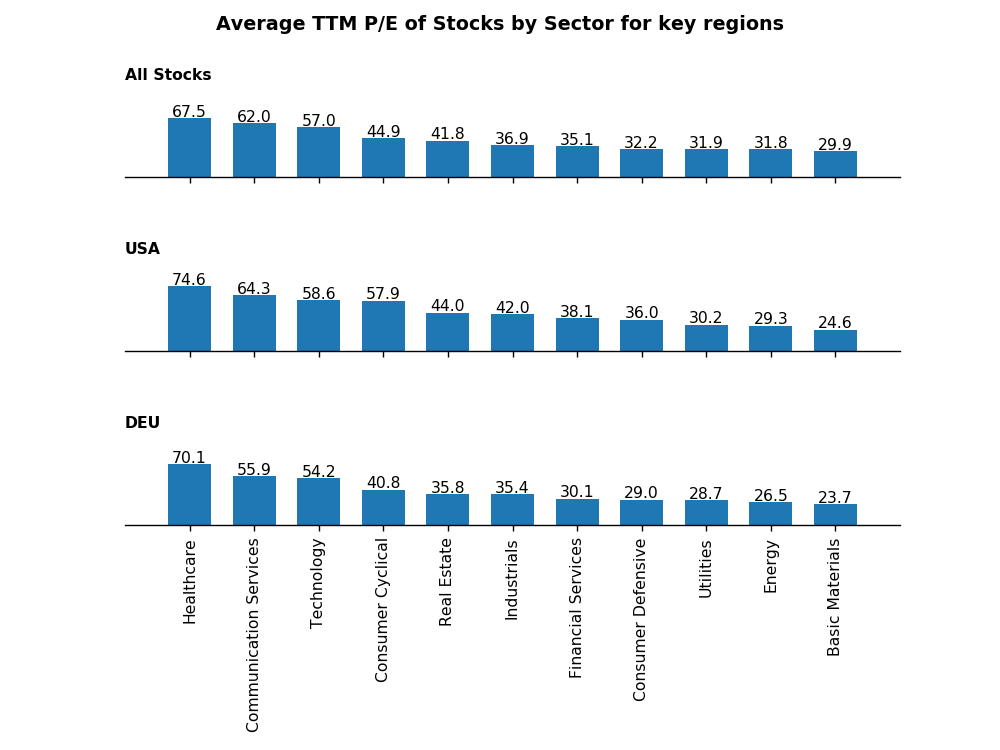

In [70]:
fig_pe, (ax_pe, ax_pe_usa, ax_pe_deu) = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(8, 6))

# All Stocks
pe = df_val_mean['PE_TTM']
x = [x*3 for x in range(len(pe))]
y = pe
bars = ax_pe.bar(x, y, width=2)
for bar in bars:
    ax_pe.text(bar.get_x()+1, bar.get_height()+1.5, '{:.1f}'.format(bar.get_height()), 
               color='black', ha='center', fontsize=9)
ax_pe.get_children()[22].set_color(None)
ax_pe.get_children()[23].set_color(None)
ax_pe.get_children()[25].set_color(None)
ax_pe.set_title('All Stocks', loc='left', fontsize=9, fontweight='bold')

# USA
pe_usa = df_val_mean_USA['PE_TTM']
x = [x*3 for x in range(len(pe_usa))]
y = pe_usa
bars = ax_pe_usa.bar(x, y, width=2)
for bar in bars:
    ax_pe_usa.text(bar.get_x()+1, bar.get_height()+1.5, '{:.1f}'.format(bar.get_height()), 
                   color='black', ha='center', fontsize=9)
ax_pe_usa.get_children()[22].set_color(None)
ax_pe_usa.get_children()[23].set_color(None)
ax_pe_usa.get_children()[25].set_color(None)
ax_pe_usa.set_title('USA', loc='left', fontsize=9, fontweight='bold')

# DEU
pe_deu = df_val_mean_DEU['PE_TTM']
x = [x*3 for x in range(len(pe_deu))]
y = pe_deu
bars = ax_pe_deu.bar(x, y, width=2)
for bar in bars:
    ax_pe_deu.text(bar.get_x()+1, bar.get_height()+1.5, '{:.1f}'.format(bar.get_height()), 
                   color='black', ha='center', fontsize=9)
ax_pe_deu.get_children()[22].set_color(None)
ax_pe_deu.get_children()[23].set_color(None)
ax_pe_deu.get_children()[25].set_color(None)
ax_pe_deu.set_title('DEU', loc='left', fontsize=9, fontweight='bold')

# Plot adjustments
plt.xticks(ticks=x, labels=y.index.tolist(), fontsize=9)
plt.axis([-3, len(x)*3, 0, 100])
plt.suptitle('Average TTM P/E of Stocks by Sector for key regions', fontsize=11, fontweight='bold')
plt.yticks([])
plt.subplots_adjust(bottom=0.3, hspace=1)

for tick in ax_pe_deu.xaxis.get_ticklabels():
    tick.set_rotation(90)

[return to the top](#top)
#### P/E by Sector for past 10 yrs for US Stocks

<IPython.core.display.Javascript object>


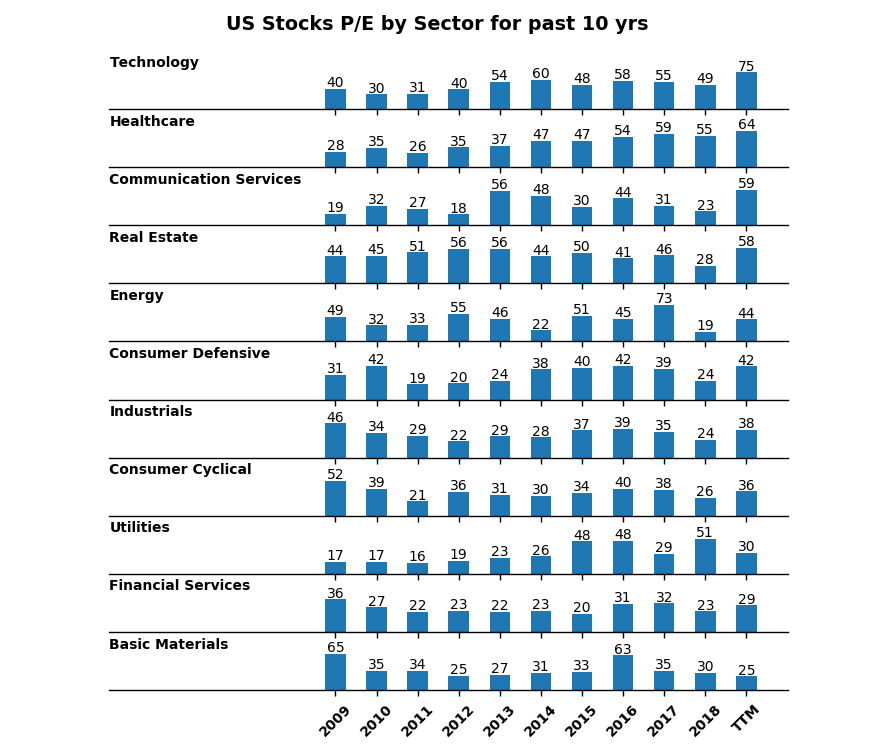

In [193]:
cols = list(filter(lambda col: col.startswith('PE_'), df.columns))[1:]

fig, axs = plt.subplots(11, 1, figsize=(7, 6), sharex=True)
sectors = df_val_mean_USA.index.values
x = list(range(11))

for sector, ax in zip(sectors, axs):
    y = df_val_mean_USA[cols].loc[sector].values
    p0 = ax.bar(x, y, width=0.5)
    #ax.set_title(sector, loc='left', fontsize=9, fontweight='bold')
    ax.spines['left'].set_color(None)
    ax.spines['right'].set_color(None)
    ax.spines['top'].set_color(None)
    for pt in list(zip(x, y)):
        if pt[1] > 0:
            ax.text(pt[0], pt[1] + max(y)*0.05, '{:.0f}'.format(pt[1]), ha='center', fontsize=8)
    ax.set_yticks([])
    ax.axis([-5.5, 11, 0, max(y)+10])
    ax.set_xlim(-5.5, 11)
    ax.text(-5.5, max(y)+10, sector, fontweight='bold', fontsize=8)
    ax0 = ax
    
plt.suptitle('US Stocks P/E by Sector for past 10 yrs', fontweight='bold', fontsize=11)
plt.subplots_adjust(top=0.91, bottom=0.08, hspace=0.4)
_ = plt.xticks(ticks=x, labels=list(map(lambda col: col[3:], cols)), fontsize=8, fontweight='bold')
for label in ax.xaxis.get_ticklabels():
    label.set_rotation(45)

[return to the top](#top)
#### P/S by Sector for past 10 yrs for US Stocks

<IPython.core.display.Javascript object>


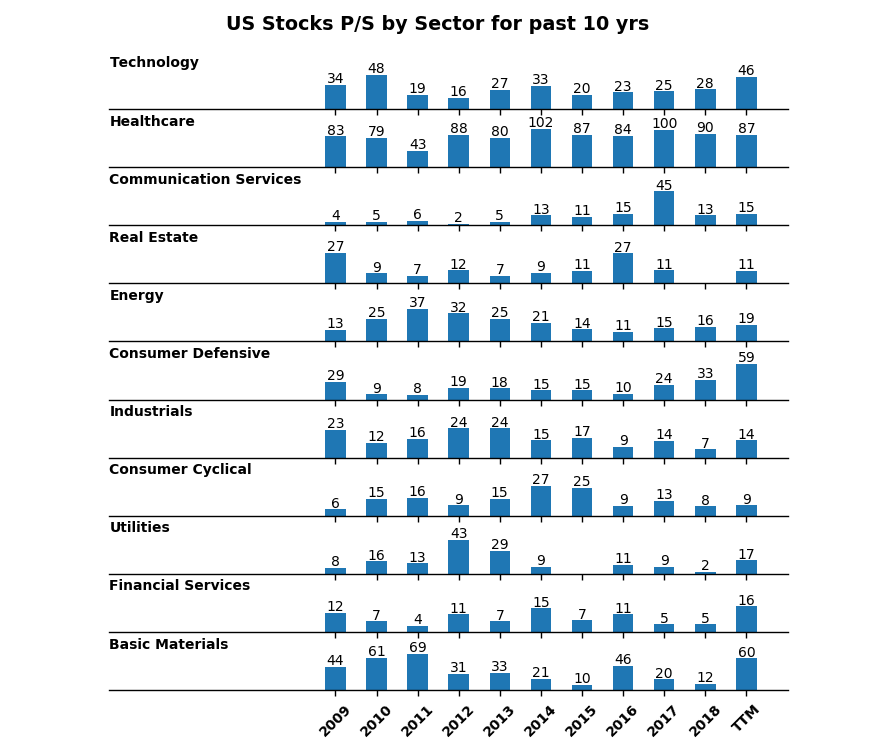

In [194]:
cols = list(filter(lambda col: col.startswith('PS_'), df.columns))

fig, axs = plt.subplots(11, 1, figsize=(7, 6), sharex=True)
sectors = df_val_mean_USA.index.values
x = list(range(11))

for sector, ax in zip(sectors, axs):
    y = df_val_mean_USA[cols].loc[sector].values
    p0 = ax.bar(x, y, width=0.5)
    #ax.set_title(sector, loc='left', fontsize=9, fontweight='bold')
    ax.spines['left'].set_color(None)
    ax.spines['right'].set_color(None)
    ax.spines['top'].set_color(None)
    for pt in list(zip(x, y)):
        if pt[1] > 0:
            ax.text(pt[0], pt[1] + max(y)*0.05, '{:.0f}'.format(pt[1]), ha='center', fontsize=8)
    ax.set_yticks([])
    ax.axis([-5.5, 11, 0, max(y)+10])
    ax.set_xlim(-5.5, 11)
    ax.text(-5.5, max(y)+10, sector, fontweight='bold', fontsize=8)
    ax0 = ax
    
plt.suptitle('US Stocks P/S by Sector for past 10 yrs', fontweight='bold', fontsize=11)
plt.subplots_adjust(top=0.91, bottom=0.08, hspace=0.4)
_ = plt.xticks(ticks=x, labels=list(map(lambda col: col[3:], cols)), fontsize=8, fontweight='bold')
for label in ax.xaxis.get_ticklabels():
    label.set_rotation(45)

[return to the top](#top)
### Stocks in the Cannabis Industry
Using stocks listed on [marijuanaindex.com](http://marijuanaindex.com/stock-quotes/north-american-marijuana-index/) under North America

In [76]:
import json

with open('input/pot_stocks.json') as file:
    pot_symbols = json.loads(file.read())
    
pot_stocks = (pd.DataFrame(pot_symbols, columns=['ticker', 'country_c3'])
               .merge(df_master, how='left', on=['ticker', 'country_c3']).drop('country', axis=1)
               .rename(columns={'country_c3':'country', 'exchange_sym':'exch'}))

pot_stocks = (pot_stocks.where(((pot_stocks['country'] == 'USA') | 
                                (pot_stocks['country'] == 'CAN')) &
                               (pot_stocks['sector'] != '—'))
              .dropna(axis=0, how='all').sort_values(by='company'))

In [77]:
msg = 'Below are the {} stocks listed on marijuanaindex.com for North America.'
print(msg.format(len(pot_stocks['company'].unique())))

pot_stocks[['country', 'ticker', 'exch', 'company', 'sector', 'industry']]

Below are the 46 stocks listed on marijuanaindex.com for North America.


,country,ticker,exch,company,sector,industry
29,CAN,TGIF,XCNQ,1933 Industries Inc,Healthcare,Drug Manufacturers - Specialty & Generic
1,USA,ACRGF,PINX,Acreage Holdings Inc Ordinary Shares (Sub Voting),Healthcare,Drug Manufacturers - Specialty & Generic
2,CAN,ACRG.U,XCNQ,Acreage Holdings Inc Ordinary Shares (Sub Voting),Healthcare,Drug Manufacturers - Specialty & Generic
37,USA,APHA,XNYS,Aphria Inc,Healthcare,Drug Manufacturers - Specialty & Generic
0,CAN,ACB,XTSE,Aurora Cannabis Inc,Healthcare,Drug Manufacturers - Specialty & Generic
36,CAN,XLY,XTSX,Auxly Cannabis Group Inc,Healthcare,Drug Manufacturers - Specialty & Generic
40,USA,CVSI,PINX,CV Sciences Inc,Healthcare,Drug Manufacturers - Specialty & Generic
32,CAN,TRST,XTSE,CannTrust Holdings Inc,Healthcare,Drug Manufacturers - Specialty & Generic
4,CAN,CNNX,XCNQ,Cannex Capital Holdings Inc,Healthcare,Drug Manufacturers - Specialty & Generic
38,USA,CGC,XNYS,Canopy Growth Corp,Healthcare,Drug Manufacturers - Specialty & Generic


<a id="value"></a>
[return to the top](#top)

# Applying various criteria to filter common stocks

Below is a list of different rules that can be applied to the data to screen stocks (development of *italicized rules* is still in progress)

- **[Rule 0](#rule99): CAGR > 7% for past 7 years**
- **[Rule 1](#rule1): No earnings deficit (loss) for past 5 or 7 years**
- **[Rule 2](#rule2): Uniterrupted and increasing Dividends for past 5 yrs**
- **[Rule 3](#rule3): P/E Ratio of 25 or less for the past 7 yrs and less then 20 for TTM**
- **[Rule 4](#rule4): Growth for the past year**
- **[Rule 5](#rule5): Current Ratio > 1.2**
- **[Rule 6](#rule6): Debt/Equity < 1.0**
- **[Rule 7](#rule7): Return on Equity > 10%**
- **[Rule X](#rulex): Stocks with insider buys in the past 3 months**

[Merge DataFrames](#mergerules) to screen stocks

[return to the top](#top)
<a id="rule99"></a>
## Rule 0. CAGR > 7% for past 5 years

Column labels in `df_keyratios`:

In [53]:
df_labels_keyratios

i0                    Revenue USD Mil
i1                     Gross Margin %
i2           Operating Income USD Mil
i3                 Operating Margin %
i4                 Net Income USD Mil
i5             Earnings Per Share USD
i6                      Dividends USD
i91                  Payout Ratio % *
i7                         Shares Mil
i8         Book Value Per Share * USD
i9        Operating Cash Flow USD Mil
i10              Cap Spending USD Mil
i11            Free Cash Flow USD Mil
i90    Free Cash Flow Per Share * USD
i80           Working Capital USD Mil
Name: 0, dtype: object

### Revenue CAGR:

In [54]:
iid = 'i0'
field = 'Rev'
label = 'CAGR_{}'.format(field)

df_rule0_Rev = (df_keyratios.where(df_keyratios['Y9'] > pd.to_datetime('2018-02-01')).dropna(axis=0, how='all'))

df_rule0_Rev[label] = 100 * ((df_rule0_Rev['{}_Y9'.format(iid)] / df_rule0_Rev['{}_Y4'.format(iid)]) ** (1/5) - 1)

cols = ['ticker_id', 'exchange_id', label] #, '{}_Y4'.format(iid), '{}_Y9'.format(iid)]
df_rule0_Rev = (df_rule0_Rev.where(df_rule0_Rev[label] >= 7).dropna(axis=0, how='all')
                .sort_values(by=label, ascending=False))[cols]

print('Total of {:,.0f} records meet this criterium.'.format(len(df_rule0_Rev)))

Total of 21,002 records meet this criterium.


### Operating Income CAGR:

In [55]:
iid = 'i2'
field = 'OpeInc'
label = 'CAGR_{}'.format(field)

df_rule0_OpeInc = (df_keyratios.where(df_keyratios['Y9'] > pd.to_datetime('2018-02-01')).dropna(axis=0, how='all'))

df_rule0_OpeInc[label] = 100 * (
    (df_rule0_OpeInc['{}_Y9'.format(iid)] / df_rule0_OpeInc['{}_Y4'.format(iid)]) ** (1/5) - 1)

cols = ['ticker_id', 'exchange_id', label]
df_rule0_OpeInc = (df_rule0_OpeInc.where(df_rule0_OpeInc[label] >= 7).dropna(axis=0, how='all')
                .sort_values(by=label, ascending=False))[cols]

print('Total of {:,.0f} records meet this criterium.'.format(len(df_rule0_OpeInc)))

Total of 21,719 records meet this criterium.


### Operating Cash Flow CAGR:

In [56]:
iid = 'i9'
field = 'OpeCF'
label = 'CAGR_{}'.format(field)

df_rule0_OpeCF = (df_keyratios.where(df_keyratios['Y9'] > pd.to_datetime('2018-02-01')).dropna(axis=0, how='all'))

df_rule0_OpeCF[label] = 100 * (
    (df_rule0_OpeCF['{}_Y9'.format(iid)] / df_rule0_OpeCF['{}_Y4'.format(iid)]) ** (1/5) - 1)

cols = ['ticker_id', 'exchange_id', label]
df_rule0_OpeCF = (df_rule0_OpeCF.where(df_rule0_OpeCF[label] >= 7).dropna(axis=0, how='all')
                .sort_values(by=label, ascending=False))[cols]

print('Total of {:,.0f} records meet this criterium.'.format(len(df_rule0_OpeCF)))

Total of 20,213 records meet this criterium.


### Free Cash Flow CAGR:

In [57]:
iid = 'i11'
field = 'FreeCF'
label = 'CAGR_{}'.format(field)

df_rule0_FreeCF = (df_keyratios.where(df_keyratios['Y9'] > pd.to_datetime('2018-02-01')).dropna(axis=0, how='all'))
df_rule0_FreeCF[label] = 100 * (
    (df_rule0_FreeCF['{}_Y9'.format(iid)] / df_rule0_FreeCF['{}_Y4'.format(iid)]) ** (1/5) - 1)

cols = ['ticker_id', 'exchange_id', label]
df_rule0_FreeCF = (df_rule0_FreeCF.where(df_rule0_FreeCF[label] >= 7).dropna(axis=0, how='all')
                .sort_values(by=label, ascending=False))[cols]

print('Total of {:,.0f} records meet this criterium.'.format(len(df_rule0_FreeCF)))

Total of 19,818 records meet this criterium.


[return to top of this section](#value),
[return to the top](#top)
<a id="rule1"></a>
### Rule 1. No earnings deficit (loss) for past 5 or 7 years
Criteria: *"Find companies with positive earnings per share growth during the past five years with no earnings deficits. Earnings need to be higher in the most recent year than five years ago. Avoiding companies with earnings deficits during the past five years will help you stay clear of high-risk companies."* [(Source)](https://cabotwealth.com/daily/value-investing/benjamin-grahams-value-stock-criteria/)

#### 5 Years: (PENDING CORRECTION OF CODE)
*a. Identify Net Income column labels in* `df_annualIS`

In [58]:
ilabel = 'Net income'
df_labels = df_labels_aIS[df_labels_aIS['value'] == ilabel].sort_values(by='value')
df_labels

,value
header,
label_i50,Net income
label_i70,Net income
label_i80,Net income


*b. Get column headers for 'Net income' values for the past 5 yrs*

In [59]:
# i_ids = [(label[-3:] + '_') for label in df_labels.index]

# def get_icols(col):
#     for i_id in i_ids:
#         if i_id in col:
#             return True
#     return False

# main_cols = ['ticker_id', 'exchange_id', 'country', 'exchange_sym', 'ticker', 'company', 'sector', 'industry',
#              'stock_type', 'style', 'Year_Y_6', 'Year_Y_5', 'Year_Y_4', 'Year_Y_3', 'Year_Y_2', 'Year_Y_1']
# data_cols = sorted(list(filter(get_icols, df_annualIS.columns)), key=lambda r: (r[-1], r[5:8]), reverse=True)

*c. Create 'Net Income' DataFrame*

In [60]:
# df_annualIS1 = df_master.merge(df_annualIS, on=['ticker_id', 'exchange_id'])

# df_netinc5 = (df_annualIS1
#               .where((df_annualIS1['security_type'] == 'Stock') & 
#                      (df_annualIS1['Year_Y_5'] > pd.to_datetime('2018-01')))
#               .dropna(axis=0, how='all')
#               .drop(['country'], axis=1)
#               .rename(columns={'country_c3':'country'})
#              )[main_cols + data_cols]

# np_netinc = df_netinc5[data_cols].values
# netinc_cols = [('NetIncome_Y' + data_cols[i * 3][-1], (i * 3, i * 3 + 1, i * 3 + 2))
#                for i in range(int(len(data_cols)/3))]

# vals = []
# for row in np_netinc:
#     row_vals = []
#     for i in range(len(netinc_cols)):
#         val = None
#         for col in netinc_cols[i][1]:
#             if not np.isnan(row[col]):
#                 val = row[col]
#                 break
#         row_vals.append(val)
#     vals.append(row_vals)
    
# df_netinc_vals = pd.DataFrame(vals, columns=list(zip(*netinc_cols))[0])
# df_netinc5 = df_netinc5[main_cols].join(df_netinc_vals)

In [61]:
# df_rule1_5 = df_netinc5.where((df_netinc5['NetIncome_Y6'] > 0) & 
#                             ((df_netinc5['NetIncome_Y5'] > 0) | (df_netinc5['NetIncome_Y5'].isna() & df_netinc5['NetIncome_Y4'].isna() & df_netinc5['NetIncome_Y3'].isna() & df_netinc5['NetIncome_Y2'].isna() & df_netinc5['NetIncome_Y1'].isna())) & 
#                             ((df_netinc5['NetIncome_Y4'] > 0) | (df_netinc5['NetIncome_Y4'].isna() & df_netinc5['NetIncome_Y3'].isna() & df_netinc5['NetIncome_Y2'].isna() & df_netinc5['NetIncome_Y1'].isna())) & 
#                             ((df_netinc5['NetIncome_Y3'] > 0) | (df_netinc5['NetIncome_Y3'].isna() & df_netinc5['NetIncome_Y2'].isna() & df_netinc5['NetIncome_Y1'].isna())) & 
#                             ((df_netinc5['NetIncome_Y2'] > 0) | (df_netinc5['NetIncome_Y2'].isna() & df_netinc5['NetIncome_Y1'].isna())) & 
#                             ((df_netinc5['NetIncome_Y1'] > 0) | (df_netinc5['NetIncome_Y1'].isna()))
#                            ).dropna(axis=0, how='all')

# df_rule1_5 = df_rule1_5[['ticker_id', 'exchange_id'] + df_rule1_5.columns.values.tolist()[-12:]]
# df_rule1_5.columns = [re.sub('Year_Y_', 'r1_Y', col) for col in df_rule1_5.columns]

# print('Total of {:,.0f} records meet this criterium.'.format(len(df_rule1_5)))

#### 5 Years:

In [86]:
cols = ['ticker_id', 'exchange_id'] + \
        [col for col in df_keyratios.columns if col.startswith('i4_') or col.startswith('Y')]

df_rule1_5 = (df_keyratios
              .where((df_keyratios['Y9'] >= pd.to_datetime('2018-01')) & 
                     (df_keyratios['i4_Y10'] > 0) & 
                     ((df_keyratios['i4_Y9'] > 0) | (df_keyratios['i4_Y9'].isna() & df_keyratios['i4_Y8'].isna() & df_keyratios['i4_Y7'].isna() & df_keyratios['i4_Y6'].isna() & df_keyratios['i4_Y5'].isna())) & 
                     ((df_keyratios['i4_Y8'] > 0) | (df_keyratios['i4_Y8'].isna() & df_keyratios['i4_Y7'].isna() & df_keyratios['i4_Y6'].isna() & df_keyratios['i4_Y5'].isna())) & 
                     ((df_keyratios['i4_Y7'] > 0) | (df_keyratios['i4_Y7'].isna() & df_keyratios['i4_Y6'].isna() & df_keyratios['i4_Y5'].isna())) & 
                     ((df_keyratios['i4_Y6'] > 0) | (df_keyratios['i4_Y6'].isna() & df_keyratios['i4_Y5'].isna())) & 
                     ((df_keyratios['i4_Y5'] > 0) | (df_keyratios['i4_Y5'].isna())))
              .dropna(axis=0, how='all'))[cols]

df_rule1_5.columns = [re.sub('i4_', 'NetIncome_r1_', col) for col in df_rule1_5.columns]
df_rule1_5.columns = [re.sub('^Y', 'r1_Y', col) for col in df_rule1_5.columns]

print('Total of {:,.0f} records meet this criterium.'.format(len(df_rule1_5)))

Total of 31,055 records meet this criterium.


#### 7 Years:

In [87]:
cols = ['ticker_id', 'exchange_id'] + \
        [col for col in df_keyratios.columns if col.startswith('i4_') or col.startswith('Y')]

df_rule1_7 = (df_keyratios
              .where((df_keyratios['Y9'] >= pd.to_datetime('2018-01')) & 
                     (df_keyratios['i4_Y10'] > 0) & 
                     ((df_keyratios['i4_Y9'] > 0) | (df_keyratios['i4_Y9'].isna() & df_keyratios['i4_Y8'].isna() & df_keyratios['i4_Y7'].isna() & df_keyratios['i4_Y6'].isna() & df_keyratios['i4_Y5'].isna() & df_keyratios['i4_Y4'].isna() & df_keyratios['i4_Y3'].isna())) & 
                     ((df_keyratios['i4_Y8'] > 0) | (df_keyratios['i4_Y8'].isna() & df_keyratios['i4_Y7'].isna() & df_keyratios['i4_Y6'].isna() & df_keyratios['i4_Y5'].isna() & df_keyratios['i4_Y4'].isna() & df_keyratios['i4_Y3'].isna())) & 
                     ((df_keyratios['i4_Y7'] > 0) | (df_keyratios['i4_Y7'].isna() & df_keyratios['i4_Y6'].isna() & df_keyratios['i4_Y5'].isna() & df_keyratios['i4_Y4'].isna() & df_keyratios['i4_Y3'].isna())) & 
                     ((df_keyratios['i4_Y6'] > 0) | (df_keyratios['i4_Y6'].isna() & df_keyratios['i4_Y5'].isna() & df_keyratios['i4_Y4'].isna() & df_keyratios['i4_Y3'].isna())) & 
                     ((df_keyratios['i4_Y5'] > 0) | (df_keyratios['i4_Y5'].isna() & df_keyratios['i4_Y4'].isna() & df_keyratios['i4_Y3'].isna())) & 
                     ((df_keyratios['i4_Y4'] > 0) | (df_keyratios['i4_Y4'].isna() & df_keyratios['i4_Y3'].isna())) & 
                     ((df_keyratios['i4_Y3'] > 0) | (df_keyratios['i4_Y3'].isna())))
              .dropna(axis=0, how='all'))[cols]

df_rule1_7.columns = [re.sub('i4_', 'NetIncome_r1_', col) for col in df_rule1_7.columns]
df_rule1_7.columns = [re.sub('^Y', 'r1_Y', col) for col in df_rule1_7.columns]

print('Total of {:,.0f} records meet this criterium.'.format(len(df_rule1_7)))

Total of 28,348 records meet this criterium.


[return to top of this section](#value),
[return to the top](#top)
<a id="rule2"></a>
### Rule 2. Uniterrupted and increasing *Dividends* for past 7 yrs

In [88]:
df_labels_keyratios

i0                    Revenue USD Mil
i1                     Gross Margin %
i2           Operating Income USD Mil
i3                 Operating Margin %
i4                 Net Income USD Mil
i5             Earnings Per Share USD
i6                      Dividends USD
i91                  Payout Ratio % *
i7                         Shares Mil
i8         Book Value Per Share * USD
i9        Operating Cash Flow USD Mil
i10              Cap Spending USD Mil
i11            Free Cash Flow USD Mil
i90    Free Cash Flow Per Share * USD
i80           Working Capital USD Mil
Name: 0, dtype: object

In [89]:
icol = df_labels_keyratios[df_labels_keyratios.str.contains('Dividends')].index[0]
icol

'i6'

In [90]:
main_cols = ['ticker_id', 'exchange_id', 
             #'country_c3', 'exchange_sym', 'ticker', 'company', 
             #'sector', 'industry', 'stock_type', 'style', 
             'Y10', 'Y9', 'Y8', 'Y7', 'Y6', 'Y5']
icols = sorted([col for col in df_keyratios.columns if icol + '_' in col], 
               key=lambda col: int(col[4:]), reverse=True)[:8]
icols

['i6_Y10', 'i6_Y9', 'i6_Y8', 'i6_Y7', 'i6_Y6', 'i6_Y5', 'i6_Y4', 'i6_Y3']

In [91]:
df_rule2 = (df_keyratios
            .where((df_keyratios['Y9'] > pd.to_datetime('2018-01')) & 
                   (df_keyratios['i6_Y10'] >= df_keyratios['i6_Y9']) &
                   ((df_keyratios['i6_Y9'] >= df_keyratios['i6_Y8']) | (df_keyratios['i6_Y2'].isna() & df_keyratios['i6_Y3'].isna() & df_keyratios['i6_Y4'].isna() & df_keyratios['i6_Y5'].isna() & df_keyratios['i6_Y6'].isna() & df_keyratios['i6_Y7'].isna() & df_keyratios['i6_Y8'].isna())) & 
                   ((df_keyratios['i6_Y8'] >= df_keyratios['i6_Y7']) | (df_keyratios['i6_Y2'].isna() & df_keyratios['i6_Y3'].isna() & df_keyratios['i6_Y4'].isna() & df_keyratios['i6_Y5'].isna() & df_keyratios['i6_Y6'].isna() & df_keyratios['i6_Y7'].isna())) & 
                   ((df_keyratios['i6_Y7'] >= df_keyratios['i6_Y6']) | (df_keyratios['i6_Y2'].isna() & df_keyratios['i6_Y3'].isna() & df_keyratios['i6_Y4'].isna() & df_keyratios['i6_Y5'].isna() & df_keyratios['i6_Y6'].isna())) &
                   ((df_keyratios['i6_Y6'] >= df_keyratios['i6_Y5']) | (df_keyratios['i6_Y2'].isna() & df_keyratios['i6_Y3'].isna() & df_keyratios['i6_Y4'].isna() & df_keyratios['i6_Y5'].isna())) &
                   ((df_keyratios['i6_Y5'] >= df_keyratios['i6_Y4']) | (df_keyratios['i6_Y2'].isna() & df_keyratios['i6_Y3'].isna() & df_keyratios['i6_Y4'].isna())) &
                   ((df_keyratios['i6_Y4'] >= df_keyratios['i6_Y3']) | (df_keyratios['i6_Y2'].isna() & df_keyratios['i6_Y3'].isna())) &
                   ((df_keyratios['i6_Y3'] >= df_keyratios['i6_Y2']) | (df_keyratios['i6_Y2'].isna())))
            .dropna(axis=0, how='all').sort_values(by='Y9', ascending=False))[main_cols + icols]

df_rule2.columns = main_cols + [col.replace('i6', 'Dividend') for col in icols]
df_rule2.columns = [re.sub('^Y', 'r2_Y', col) for col in df_rule2.columns]

print('Total of {:,.0f} records meet this criterium.'.format(len(df_rule2)))

Total of 11,673 records meet this criterium.


[return to top of this section](#value),
[return to the top](#top)
<a id="rule3"></a>
### Rule 3. P/E Ratio of 25 or less for the past 7 yrs and less then 20 for TTM

In [92]:
pe_cols = [col for col in df_vals.columns if 'PE_' in col]
pe_cols = ['ticker_id', 'exchange_id'] + [pe_cols[len(pe_cols)-i-1] for i in range(len(pe_cols))][:8]
pe_cols

['ticker_id',
 'exchange_id',
 'PE_TTM',
 'PE_2018',
 'PE_2017',
 'PE_2016',
 'PE_2015',
 'PE_2014',
 'PE_2013',
 'PE_2012']

In [93]:
df_rule3 = (df_vals[pe_cols]
            .where((df_vals['PE_TTM'] <= 20) &
                   (df_vals['PE_2018'] <= 25) &
                   ((df_vals['PE_2017'] <= 25) | (df_vals['PE_2012'].isna() & df_vals['PE_2013'].isna() & df_vals['PE_2014'].isna() & df_vals['PE_2015'].isna() & df_vals['PE_2016'].isna() & df_vals['PE_2017'].isna())) &
                   ((df_vals['PE_2016'] <= 25) | (df_vals['PE_2012'].isna() & df_vals['PE_2013'].isna() & df_vals['PE_2014'].isna() & df_vals['PE_2015'].isna() & df_vals['PE_2016'].isna())) &
                   ((df_vals['PE_2015'] <= 25) | (df_vals['PE_2012'].isna() & df_vals['PE_2013'].isna() & df_vals['PE_2014'].isna() & df_vals['PE_2015'].isna())) &
                   ((df_vals['PE_2014'] <= 25) | (df_vals['PE_2012'].isna() & df_vals['PE_2013'].isna() & df_vals['PE_2014'].isna())) &
                   ((df_vals['PE_2013'] <= 25) | (df_vals['PE_2012'].isna() & df_vals['PE_2013'].isna())) & 
                   ((df_vals['PE_2012'] <= 25) | (df_vals['PE_2012'].isna())))
            .dropna(axis=0, how='all').sort_values(by='PE_TTM'))

print('Total of {:,.0f} records meet this criterium.'.format(len(df_rule3)))

Total of 10,949 records meet this criterium.


[return to top of this section](#value),
[return to the top](#top)
<a id="rule4"></a>
## Rule 4. Growth for the past year

In [94]:
df_labels_growth

gr_revenue               Revenue %
i28                 Year over Year
i29                 3-Year Average
i30                 5-Year Average
i31                10-Year Average
gr_operating    Operating Income %
i32                 Year over Year
i33                 3-Year Average
i34                 5-Year Average
i35                10-Year Average
gr_ni                 Net Income %
i81                 Year over Year
i82                 3-Year Average
i83                 5-Year Average
i84                10-Year Average
gr_eps                       EPS %
i36                 Year over Year
i37                 3-Year Average
i38                 5-Year Average
i39                10-Year Average
Name: 0, dtype: object

### Revenue

In [95]:
iid = 'i28'; label = '{}_gr_Y9'.format(iid); col = 'Rev';
cols = ['ticker_id', 'exchange_id', 'gr_Y9', label]
df_rule4_Rev = (df_growth[cols]
                .where((df_growth[label] > 0) & (df_growth['gr_Y9'] > pd.to_datetime('2018-02-01')))
                .dropna(axis=0, how='all').sort_values(by='gr_Y9')
                .rename(columns={label:'{}_Growth_Y9'.format(col)}))
print('Total of {:,.0f} records meet this criterium.'.format(len(df_rule4_Rev)))

Total of 41,754 records meet this criterium.


### Operating Income

In [96]:
iid = 'i32'; label = '{}_gr_Y9'.format(iid); col = 'OpeInc';
cols = ['ticker_id', 'exchange_id', 'gr_Y9', label]
df_rule4_OpeInc = (df_growth[cols]
                .where((df_growth[label] > 0) & (df_growth['gr_Y9'] > pd.to_datetime('2018-02-01')))
                .dropna(axis=0, how='all').sort_values(by='gr_Y9')
                .rename(columns={label:'{}_Growth_Y9'.format(col)}))
print('Total of {:,.0f} records meet this criterium.'.format(len(df_rule4_OpeInc)))

Total of 25,044 records meet this criterium.


### Net Income

In [97]:
iid = 'i81'; label = '{}_gr_Y9'.format(iid); col = 'NetInc';
cols = ['ticker_id', 'exchange_id', 'gr_Y9', label]
df_rule4_NetInc = (df_growth[cols]
                .where((df_growth[label] > 0) & (df_growth['gr_Y9'] > pd.to_datetime('2018-02-01')))
                .dropna(axis=0, how='all').sort_values(by='gr_Y9')
                .rename(columns={label:'{}_Growth_Y9'.format(col)}))
print('Total of {:,.0f} records meet this criterium.'.format(len(df_rule4_NetInc)))

Total of 25,156 records meet this criterium.


[return to top of this section](#value),
[return to the top](#top)
<a id="rule5"></a>
### Rule 5. Current Ratio > 1.2

In [209]:
df_labels_finhealth[-5:]

lfh_liquidity    Liquidity/Financial Health
i65                           Current Ratio
i66                             Quick Ratio
i67                      Financial Leverage
i68                             Debt/Equity
Name: 0, dtype: object

In [210]:
col = 'i65_lfh_Y10'
df_rule5 = (df_finhealth[['ticker_id', 'exchange_id', col]]
            .where((df_finhealth[col] > 1.2) | (df_finhealth[col].isna()))
            .dropna(axis=0, how='all')
            .rename(columns={col:'current_ratio'}))
print('Total of {:,.0f} records meet this criterium.'.format(len(df_rule5)))

Total of 53,260 records meet this criterium.


[return to top of this section](#value),
[return to the top](#top)
<a id="rule6"></a>
### Rule 6. Debt/Equity < 1.5

In [212]:
col = 'i68_lfh_Y10'
df_rule6 = (df_finhealth[['ticker_id', 'exchange_id', col]]
            .where((df_finhealth[col] < 1.5) | (df_finhealth[col].isna()))
            .dropna(axis=0, how='all')
            .rename(columns={col:'debt2equity'}))
print('Total of {:,.0f} records meet this criterium.'.format(len(df_rule6)))

Total of 71,539 records meet this criterium.


[return to top of this section](#value),
[return to the top](#top)
<a id="rule7"></a>
### Rule 7. Return on Equity > 10%

In [213]:
df_labels_profitab[-9:]

pr_profit                   Profitability
i21                            Tax Rate %
i22                          Net Margin %
i23              Asset Turnover (Average)
i24                    Return on Assets %
i25          Financial Leverage (Average)
i26                    Return on Equity %
i27          Return on Invested Capital %
i95                     Interest Coverage
Name: 0, dtype: object

In [222]:
col = 'i26_pr_pro_Y10'
df_rule7 = (df_profitab[['ticker_id', 'exchange_id', col]]
            .where((df_profitab[col] > 10) | (df_profitab[col].isna()))
            .dropna(axis=0, how='all')
            .rename(columns={col:'return_on_equity'}))
print('Total of {:,.0f} records meet this criterium.'.format(len(df_rule7)))

Total of 33,846 records meet this criterium.


[return to top of this section](#value),
[return to the top](#top)
<a id="rulex"></a>
### Rule X. Stocks with insider buys in the past 3 months

In [190]:
datefilter = pd.to_datetime(DT.date.today()-DT.timedelta(days=90))

df_insiderbuys0 = (df_insidertrades
                  .where((df_insidertrades['type'] == 'Buy') & (df_insidertrades['date'] >= datefilter))
                  .dropna(axis=0, how='all').groupby(['ticker_id', 'exchange_id']).sum())


df_insiderbuys = (df_master.set_index(['ticker_id', 'exchange_id'])
                  .join(df_insiderbuys0, how='inner').reset_index()
                  .groupby(['company', 'sector', 'industry']).mean().round(1)
                  .sort_values(by='value', ascending=False)
                 )[['openprice', 'yield', 'quantity', 'value']]

print('Total of {:,.0f} records meet this criterium.'.format(len(df_insiderbuys)))

Total of 667 records meet this criterium.


In [191]:
with open('doc/df_insiderbuys.csv', 'w') as file:
    file.write(df_insiderbuys.to_csv())

[return to top of this section](#value),
[return to the top](#top)
<a id="mergerules"></a>
### Merging DataFrames 

In [192]:
df_master.columns.values

array(['ticker_id', 'exchange_id', 'update_date', 'ticker', 'company',
       'exchange', 'exchange_sym', 'industry', 'sector', 'country',
       'country_c2', 'country_c3', 'security_type_code', 'security_type',
       'stock_type', 'style', 'openprice', 'lastprice', 'day_hi',
       'day_lo', '_52wk_hi', '_52wk_lo', 'yield', 'lastvol', 'avevol',
       'PE_Forward', 'pb', 'ps', 'pc', 'lastdate', 'currency',
       'currency_code', 'fy_end'], dtype=object)

In [227]:
df_rules = (df_master[df_master['security_type'] == 'Stock']
            .merge(df_rule0_Rev, on=['ticker_id', 'exchange_id'])    # CAGR > 7% for past 5 yrs - Revenue
            .merge(df_rule0_OpeInc, on=['ticker_id', 'exchange_id']) # CAGR > 7% for past 5 yrs - Ope. Income
            .merge(df_rule0_OpeCF, on=['ticker_id', 'exchange_id'])  # CAGR > 7% for past 5 yrs - Ope. Cash Flow
            .merge(df_rule0_FreeCF, on=['ticker_id', 'exchange_id']) # CAGR > 7% for past 5 yrs - Free Cash Flow
            .merge(df_rule1_5, on=['ticker_id', 'exchange_id'])      # No earnings deficit for past 5 yrs
            .merge(df_rule2, on=['ticker_id', 'exchange_id'])        # Uniterrupted Dividends for past 7 yrs
            .merge(df_rule3, on=['ticker_id', 'exchange_id'])        # P/E Ratio of 25 or less for past 7 yrs
            .merge(df_rule4_Rev, on=['ticker_id', 'exchange_id'])    # Growth for the past year - Revenue
            .merge(df_rule4_OpeInc, on=['ticker_id', 'exchange_id']) # Growth for the past year - Ope. Income
            .merge(df_rule4_NetInc, on=['ticker_id', 'exchange_id']) # Growth for the past year - Net Income
            .merge(df_rule5, on=['ticker_id', 'exchange_id'])        # Current Ratio > 1.2
            .merge(df_rule6, on=['ticker_id', 'exchange_id'])        # Debt/Equity < 1.0
            .merge(df_rule7, on=['ticker_id', 'exchange_id'])        # Return on Equity > 10%
            #.merge(df_insiderbuys0, on=['ticker_id', 'exchange_id'])  # Insider buys in the past 3 months
            .merge(df_vals[['ticker_id', 'exchange_id', 'PB_TTM', 'PS_TTM', 'PC_TTM']], 
                   on=['ticker_id', 'exchange_id'])
            
            .groupby(['company', 'sector', 'industry']).mean().round(1)
           )[['openprice', 'Dividend_Y10', 'yield', '_52wk_hi', '_52wk_lo',
              'PE_TTM', 'PB_TTM', 'PS_TTM', 'PC_TTM', 'current_ratio', 'debt2equity', 'return_on_equity',
              'CAGR_Rev', 'CAGR_OpeInc', 'CAGR_OpeCF', 'CAGR_FreeCF', 
              'Rev_Growth_Y9', 'OpeInc_Growth_Y9', 'NetInc_Growth_Y9'#, 'value'
              ]]

total_companies = df_master[df_master['security_type'] == 'Stock'].groupby('company').count()
msg = 'A total of {:,.0f} stocks meet these criteria out of {:,.0f} (as of {})'
print(msg.format(len(df_rules), len(total_companies), DT.date.today()))

A total of 59 stocks meet these criteria out of 27,270 (as of 2019-05-04)


In [228]:
df_rules

,,,openprice,Dividend_Y10,yield,_52wk_hi,_52wk_lo,PE_TTM,PB_TTM,PS_TTM,PC_TTM,current_ratio,debt2equity,return_on_equity,CAGR_Rev,CAGR_OpeInc,CAGR_OpeCF,CAGR_FreeCF,Rev_Growth_Y9,OpeInc_Growth_Y9,NetInc_Growth_Y9
company,sector,industry,,,,,,,,,,,,,,,,,,,
Ado Properties SA,Real Estate,Real Estate Services,46.5,0.6,1.3,55.3,28.3,5.3,1.0,13.2,19.8,1.4,0.7,19.6,46.5,43.1,47.3,47.0,20.2,17.4,8.7
Apple Inc,Technology,Consumer Electronics,184.9,2.9,1.4,1809.2,91.8,16.4,8.0,3.8,12.9,1.3,0.8,46.1,9.2,7.7,7.6,7.5,15.9,15.6,23.1
BG Staffing Inc,Industrials,Staffing & Outsourcing Services,22.1,1.2,5.1,27.4,14.3,13.0,3.6,0.8,12.4,2.1,0.2,33.5,13.6,36.9,55.2,55.2,5.2,36.6,200.1
Barratt Developments PLC,Consumer Cyclical,Residential Construction,7.1,0.3,4.5,7.5,4.9,8.6,1.4,1.2,9.2,3.8,0.0,16.6,13.3,27.9,25.4,25.3,4.8,7.9,9.1
Barratt Developments PLC ADR,Consumer Cyclical,Residential Construction,15.3,0.9,7.6,17.0,10.5,8.3,1.3,1.2,8.9,3.8,0.0,16.6,13.3,27.9,25.4,25.3,4.8,7.9,9.1
Beijing North Star Co Ltd Class H,Real Estate,Real Estate - General,1.0,0.1,4.4,1.1,0.6,4.8,0.5,0.4,3.3,1.7,1.3,12.5,26.5,22.8,17.4,19.9,15.6,48.7,4.3
Bellway PLC,Consumer Cyclical,Residential Construction,652.6,1.4,4.5,722.4,496.8,7.1,1.4,1.2,13.4,4.2,NaN,21.5,21.6,34.0,33.9,34.4,15.6,14.2,14.5
Billington Holdings PLC,Industrials,Engineering & Construction,290.1,0.1,3.9,309.9,232.5,8.9,1.6,0.5,7.8,1.5,0.1,17.8,14.9,38.0,20.1,24.6,6.0,12.9,15.6
CPL Resources PLC,Industrials,Staffing & Outsourcing Services,565.0,0.1,2.3,600.0,500.0,10.0,1.8,0.3,7.9,2.0,NaN,19.2,9.6,8.4,38.0,44.7,14.8,16.2,20.1


In [229]:
with open('doc/df_rules.csv', 'w') as file:
    file.write(df_rules.to_csv())

<a id="additional"></a>
[return to the top](#top)

## Additional sample / test code